<a href="https://colab.research.google.com/gist/aah-41350/db923d8b12e27dc2cba24b64ed3f39fa/azfarml_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           699 non-null    int64 
 1   clump_thickness              699 non-null    int64 
 2   uniformity_cell_size         699 non-null    int64 
 3   uniformity_cell_shape        699 non-null    int64 
 4   marginal_adhesion            699 non-null    int64 
 5   single_epithelial_cell_size  699 non-null    int64 
 6   bare_nuclei                  699 non-null    object
 7   bland_chromatin              699 non-null    int64 
 8   normal_nucleoli              699 non-null    int64 
 9   mitoses                      699 non-null    int64 
 10  diagnosis                    699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB
Total NaN counts in each column:
 ID                              0
clump_thickness                 0


<ipython-input-1-38540d76aaa1>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcw_cleaned['bare_nuclei'] = bcw_cleaned['bare_nuclei'].astype(int)
<ipython-input-1-38540d76aaa1>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcw_cleaned['diagnosis'] = bcw_cleaned['diagnosis'].map({2: 0, 4: 1})


Updated unique values in 'diagnosis': [0 1]
Class distribution before oversampling:
 diagnosis
0    439
1    236
Name: count, dtype: int64

Class distribution after oversampling:
 diagnosis
0    439
1    439
Name: count, dtype: int64
Cross-Validation AUC Scores: [0.9916064  0.99283316 0.9916064  0.99967346 0.99869383]
Average AUC Score: 0.9948826529400587

Feature Importances:
                        Feature  Importance
0              clump_thickness    0.039142
1         uniformity_cell_size    0.335079
2        uniformity_cell_shape    0.206633
3            marginal_adhesion    0.022549
4  single_epithelial_cell_size    0.093491
5                  bare_nuclei    0.165518
6              bland_chromatin    0.107891
7              normal_nucleoli    0.024711
8                      mitoses    0.004986


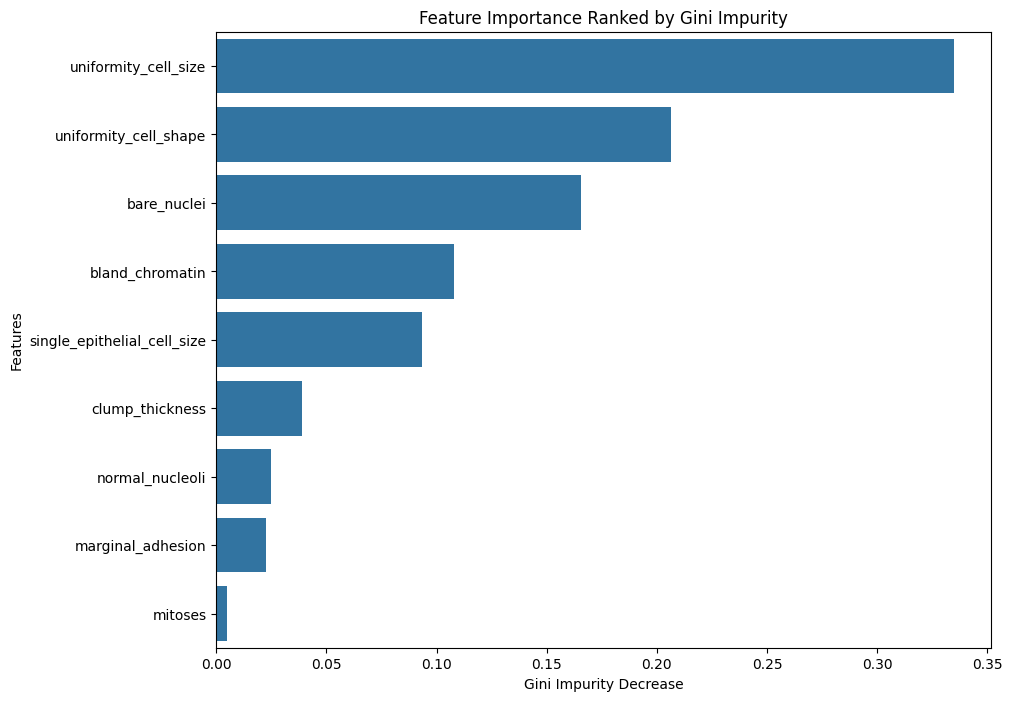

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Import data file from GItHub
url = 'https://raw.githubusercontent.com/khoocheeshin/HIA303BreastCancerProject/refs/heads/main/Selected-data-and-description-files/breast-cancer-wisconsin.data'

# Load the data file into a DataFrame
bcw = pd.read_csv(url, header=None)

# DataFrame Structuring
# Rename columns
column_names = [
    'ID', 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape',
    'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei',
    'bland_chromatin', 'normal_nucleoli', 'mitoses', 'diagnosis'
]
bcw.columns = column_names

# Overview of DataFrame: range of rows, number of columns, column names, non null counts and data types
bcw.info()

# Data Cleaning
# 1. Check for duplicate rows
duplicates = bcw[bcw.duplicated()]

# Remove duplicate rows
bcw_cleaned = bcw.drop_duplicates()

# 2. Check for missing values
# Replace the missing values (i.e. with “?”) with a NaN (Not a Number) value
bcw_cleaned = bcw_cleaned.replace('?', np.nan)

# Count the total number of NaN values in each column
nan_counts = bcw_cleaned.isnull().sum()
# Display the total NaN counts in each column
print("Total NaN counts in each column:\n", nan_counts)

# Isolate rows with missing values
rows_with_missing_values = bcw_cleaned[bcw_cleaned.isnull().any(axis=1)]

# Display rows with missing values
print("Rows with missing values:")
print(rows_with_missing_values)

# Count the number of rows with missing values
print(f"\nTotal number of rows with missing values: {len(rows_with_missing_values)}")

# Check the distribution of the diagnosis column of bcw_cleaned
print("Distribution of 'diagnosis' column before removing rows with missing values:")
print(bcw_cleaned['diagnosis'].value_counts(normalize=True) * 100)

# Remove rows with missing values
bcw_cleaned = bcw_cleaned.dropna()

# Verify the rows with missing values are removed
nan_counts_post = bcw_cleaned.isnull().sum()
print("Total NaN counts in each column after removal:\n", nan_counts_post)
print(bcw_cleaned.info())

# Check the distribution of the diagnosis column after removal
print("\nDistribution of 'diagnosis' column after removing rows with missing values:")
print(bcw_cleaned['diagnosis'].value_counts(normalize=True) * 100)

# 3. Check for data consistency in the target column (2 = benign and 4 = malignant)
# and feature columns (integer 1 to 10)
for column in bcw_cleaned.columns:
    if column != 'ID':
        unique_values = bcw_cleaned[column].unique()
        print(f"Unique values in {column}: {unique_values}")

# 4. Convert datatype of bare_nuclei column from object to integer
bcw_cleaned['bare_nuclei'] = bcw_cleaned['bare_nuclei'].astype(int)

# 5. Drop the ID column
df = bcw_cleaned.drop(columns=['ID'])

# 1. Standardization for data in target column
# Map the diagnosis values: 2 -> 0 (benign), 4 -> 1 (malignant)
bcw_cleaned['diagnosis'] = bcw_cleaned['diagnosis'].map({2: 0, 4: 1})
bcw_cleaned.info()
# Verify the mapping
print("Updated unique values in 'diagnosis':", bcw_cleaned['diagnosis'].unique())

# 2. Feature scaling using RobustScaler
features = [
    'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape',
    'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei',
    'bland_chromatin', 'normal_nucleoli', 'mitoses'
]

# Initialize the scaler
scaler = RobustScaler()

# Apply scaling to the features (exclude ID and diagnosis columns)
X_scaled = scaler.fit_transform(bcw_cleaned[features])

# Create a new DataFrame with scaled features and diagnosis
bcw_scaled = pd.DataFrame(X_scaled, columns=features)
# Reset index of bcw_cleaned to prevent misalignment
bcw_cleaned.reset_index(drop=True, inplace=True)
bcw_scaled['diagnosis'] = bcw_cleaned['diagnosis']

# SMOTE (Synthetic Minority Over-sampling Technique)
# Separate features and target variable (diagnosis)
X = bcw_scaled.drop(columns=['diagnosis'])
y = bcw_scaled['diagnosis']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)

# Fit and apply SMOTE on the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with balanced features and target variable
bcw_balanced = pd.concat([X_resampled, y_resampled], axis=1)

# Display the class distribution before and after oversampling
print("Class distribution before oversampling:\n", y.value_counts())
print("\nClass distribution after oversampling:\n", y_resampled.value_counts())

# Perform train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    bcw_balanced.drop(columns=['diagnosis']),
    bcw_balanced['diagnosis'],
    test_size=0.2, random_state=42)

# Create DataFrames for training and testing sets
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Display the first 20 rows of train data
train_data.head(20)

# Feature selection using Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Extract features and target variable
X_rf = bcw_balanced.drop(columns=['diagnosis'])
y_rf = bcw_balanced['diagnosis']

# Initialize RandomForest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# 5-Fold Cross-Validation using AUC as the scoring metric
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf, X_rf, y_rf, cv=cv, scoring='roc_auc')

# Fit the Random Forest model to get feature importances
rf.fit(X_rf, y_rf)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_rf.columns,
    'Importance': feature_importances
})

print("Cross-Validation AUC Scores:", scores)
print("Average AUC Score:", np.mean(scores))
print("\nFeature Importances:\n", feature_importance_df)

# Sort the DataFrame by importance in ascending order for the plot
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

plt.title('Feature Importance Ranked by Gini Impurity')
plt.xlabel('Gini Impurity Decrease')
plt.ylabel('Features')

plt.show()

In [2]:
# Define features based on importance
all_features = X_train.columns.tolist()
top_8_features = ['uniformity_cell_size', 'uniformity_cell_shape',
                  'single_epithelial_cell_size', 'bare_nuclei',
                  'bland_chromatin', 'clump_thickness', 'normal_nucleoli',
                  'marginal_adhesion']
top_6_features = ['uniformity_cell_size', 'uniformity_cell_shape',
                  'single_epithelial_cell_size', 'bare_nuclei',
                  'bland_chromatin', 'clump_thickness']

In [3]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9772727272727273

The optimal number of neighbors is  7 


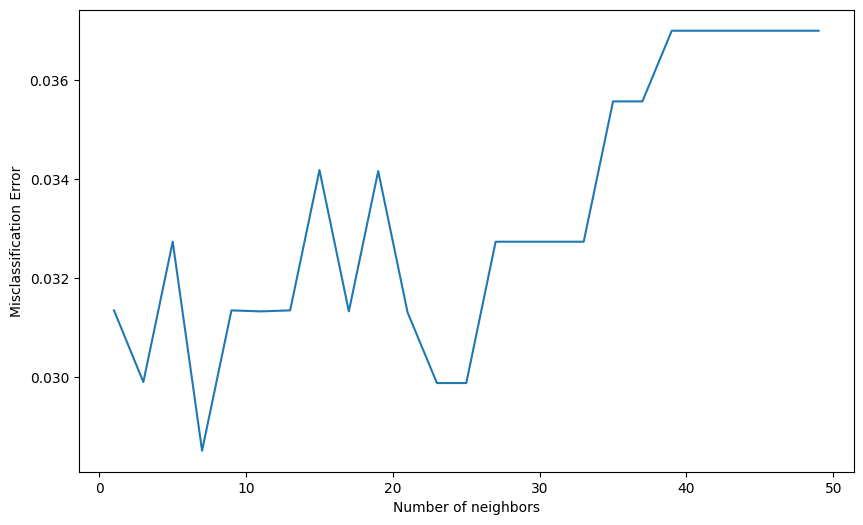

In [4]:
neighbors = []
cv_scores = []

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# Perform 10-fold cross validation
for k in range(1, 51, 2):
	neighbors.append(k)
	knn = KNeighborsClassifier(n_neighbors = k)
	scores = cross_val_score(
		knn, X_train, y_train, cv = 10, scoring = 'accuracy')
	cv_scores.append(scores.mean())

MSE = [1-x for x in cv_scores]

 # Determining the best value for k
optimal_k = neighbors[MSE.index(min(MSE))]
print('The optimal number of neighbors is % d ' % optimal_k)

# Plot misclassification error versus k
plt.figure(figsize = (10, 6))
plt.plot(neighbors, MSE)
plt.xlabel('Number of neighbors')
plt.ylabel('Misclassification Error')
plt.show()

In [5]:
def train_and_evaluate(features, feature_set_name):
    print(f"\nTraining KNN with {feature_set_name}...")
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]

    # Initialize KNN
    knn = KNeighborsClassifier(n_neighbors = 10)
    knn.fit(X_train_subset, y_train)

    # 10 fold best parameters
    from sklearn.model_selection import cross_val_score

    for k in range(1, 51, 2):
      neighbors.append(k)
      knn = KNeighborsClassifier(n_neighbors = k)
      scores = cross_val_score(
          knn, X_train, y_train, cv = 10, scoring = 'accuracy')
      cv_scores.append(scores.mean())

      MSE = [1-x for x in cv_scores]

    # Retrain the model on the entire training set using the best parameters
    optimal_k = neighbors[MSE.index(min(MSE))]
    optimized_KNN = KNeighborsClassifier(n_neighbors = optimal_k)
    optimized_KNN.fit(X_train_subset, y_train)

    # Evaluate the final model on the test set
    y_pred = optimized_KNN.predict(X_test_subset)
    y_pred_proba = optimized_KNN.predict_proba(X_test_subset)[:, 1]

    print(f"\nClassification Report for testing KNN with {feature_set_name}:\n")
    print(classification_report(y_test, y_pred, digits=4))
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC Score for LR with {feature_set_name}: {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()  # Extract true negatives, false positives, false negatives, true positives

    # Visualization of Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Sensitivity
    sensitivity = tp / (tp + fn)
    # Specificity
    specificity = tn / (tn + fp)
    # Positive Predictive Value (PPV)
    ppv = tp / (tp + fp)
    # Negative Predictive Value (NPV)
    npv = tn / (tn + fn)

    print(f"Sensitivity for {feature_set_name}: {sensitivity:.4f}")
    print(f"Specificity for {feature_set_name}: {specificity:.4f}")
    print(f"Positive Predictive Value (PPV) for {feature_set_name}: {ppv:.4f}")
    print(f"Negative Predictive Value (NPV) for {feature_set_name}: {npv:.4f}")


    return auc_score, sensitivity, specificity, ppv, npv


Training KNN with All Features...

Classification Report for testing KNN with All Features:

              precision    recall  f1-score   support

           0     0.9884    0.9659    0.9770        88
           1     0.9667    0.9886    0.9775        88

    accuracy                         0.9773       176
   macro avg     0.9775    0.9773    0.9773       176
weighted avg     0.9775    0.9773    0.9773       176

AUC Score for LR with All Features: 0.9938


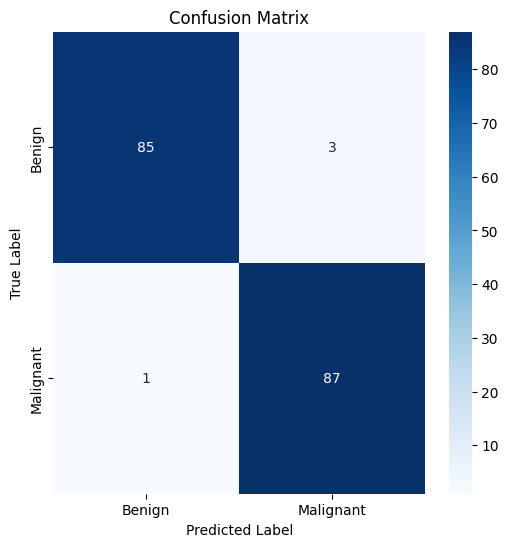

Sensitivity for All Features: 0.9886
Specificity for All Features: 0.9659
Positive Predictive Value (PPV) for All Features: 0.9667
Negative Predictive Value (NPV) for All Features: 0.9884

Training KNN with Top 8 Features...

Classification Report for testing KNN with Top 8 Features:

              precision    recall  f1-score   support

           0     0.9884    0.9659    0.9770        88
           1     0.9667    0.9886    0.9775        88

    accuracy                         0.9773       176
   macro avg     0.9775    0.9773    0.9773       176
weighted avg     0.9775    0.9773    0.9773       176

AUC Score for LR with Top 8 Features: 0.9859


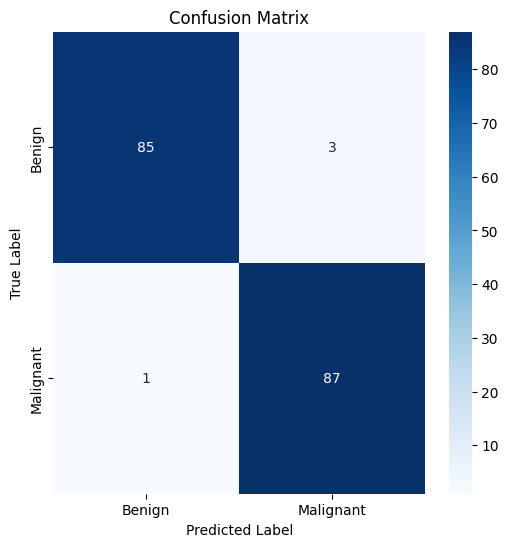

Sensitivity for Top 8 Features: 0.9886
Specificity for Top 8 Features: 0.9659
Positive Predictive Value (PPV) for Top 8 Features: 0.9667
Negative Predictive Value (NPV) for Top 8 Features: 0.9884

Training KNN with Top 6 Features...

Classification Report for testing KNN with Top 6 Features:

              precision    recall  f1-score   support

           0     0.9770    0.9659    0.9714        88
           1     0.9663    0.9773    0.9718        88

    accuracy                         0.9716       176
   macro avg     0.9717    0.9716    0.9716       176
weighted avg     0.9717    0.9716    0.9716       176

AUC Score for LR with Top 6 Features: 0.9892


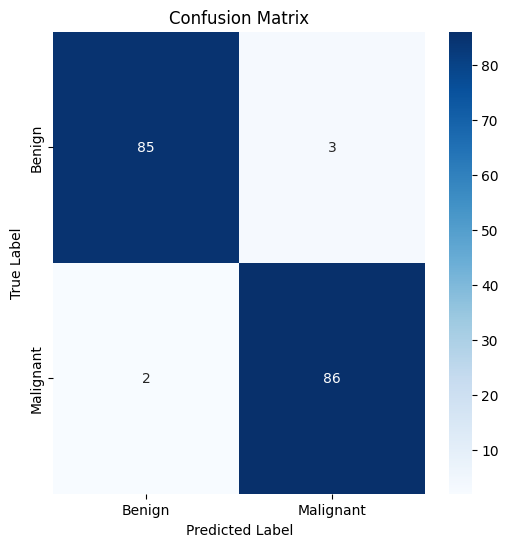

Sensitivity for Top 6 Features: 0.9773
Specificity for Top 6 Features: 0.9659
Positive Predictive Value (PPV) for Top 6 Features: 0.9663
Negative Predictive Value (NPV) for Top 6 Features: 0.9770


In [6]:
results_KNN = {}
results_KNN['All Features'] = train_and_evaluate(all_features, "All Features")
results_KNN['Top 8 Features'] = train_and_evaluate(top_8_features, "Top 8 Features")
results_KNN['Top 6 Features'] = train_and_evaluate(top_6_features, "Top 6 Features")